In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

In [2]:
# Primary Admissions information
df = pd.read_csv("ADMISSIONS.csv")

# Patient specific info such as gender
df_pat = pd.read_csv("Length_of_stay/PATIENTS.csv")

# Diagnosis for each admission to hospital
df_diagcode = pd.read_csv("Length_of_stay/DIAGNOSES_ICD.csv")

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_csv("Length_of_stay/ICUSTAYS.csv")

In [3]:
print('Dataset has {} number of unique admission events.'.format(df['hadm_id'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['subject_id'].nunique()))

Dataset has 129 number of unique admission events.
Dataset has 100 number of unique patients.


In [4]:
# Convert admission and discharge times to datatime type
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])

In [5]:
# Calculating the Length of Stay variable using the difference between Discharge time and Admit time 
# Convert timedelta type into float 'days'. Note: There are 86400 seconds in a day
df['LOS'] = (df['dischtime'] - df['admittime']).dt.total_seconds()/86400

In [6]:
df['LOS'].describe()

count    129.000000
mean       9.332332
std       12.720450
min        0.038194
25%        3.314583
50%        6.634028
75%       10.645139
max      123.984722
Name: LOS, dtype: float64

In [7]:
df['LOS']

0       8.837500
1      13.852083
2       2.650694
3       8.057639
4       0.636806
         ...    
124    10.045139
125     0.552778
126    36.011806
127     1.253472
128     9.615278
Name: LOS, Length: 129, dtype: float64

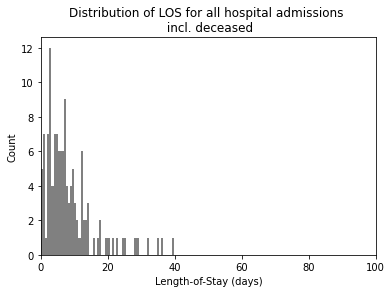

In [8]:
# Plot LOS Distribution
plt.hist(df['LOS'], bins=200, color = '0.5')
plt.xlim(0, 100)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show()

In [9]:
# Dropping the columns that are not needed
df.drop(columns=['dischtime', 'row_id', 
                'edregtime', 'edouttime', 'hospital_expire_flag',
                'has_chartevents_data'], inplace=True)

In [10]:
df

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,diagnosis,LOS
0,10006,142345,2164-10-23 21:09:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,SEPSIS,8.837500
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,HEPATITIS B,13.852083
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,SEPSIS,2.650694
3,10017,199207,2149-05-26 17:19:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,HUMERAL FRACTURE,8.057639
4,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,ALCOHOLIC HEPATITIS,0.636806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,44083,198330,2112-05-28 15:45:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,SINGLE,WHITE,PERICARDIAL EFFUSION,10.045139
125,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,ALTERED MENTAL STATUS,0.552778
126,44212,163189,2123-11-24 14:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,ENGL,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...,36.011806
127,44222,192189,2180-07-19 06:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,BRADYCARDIA,1.253472


In [11]:
# Mapping the dead and alive value of patients who died in hospital as 1 and 0
df['deceased'] = df['deathtime'].notnull().map({True:1, False:0})

In [12]:
print("{} of {} patients died in the hospital".format(df['deceased'].sum(), 
                                                     df['subject_id'].nunique()))

40 of 100 patients died in the hospital


In [13]:
# Descriptive analysis of patients who died during the stay in ICU
df['LOS'].loc[df['deceased'] == 0].describe()

count     89.000000
mean       9.766526
std       13.934030
min        0.980556
25%        4.104167
50%        6.830556
75%       10.146528
max      123.984722
Name: LOS, dtype: float64

In [14]:
# Club the Ethnicity categories into 5 broad categories
df['ethnicity'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ethnicity'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ethnicity'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ethnicity'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ethnicity'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ethnicity'].loc[~df['ethnicity'].isin(df['ethnicity'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ethnicity'].value_counts()

C:\Users\neetu\anaconda3\envs\master\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


WHITE                                                       86
HISPANIC/LATINO                                             17
OTHER/UNKNOWN                                               17
BLACK/AFRICAN AMERICAN                                       7
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE     2
Name: ethnicity, dtype: int64

In [15]:
# Bar plot function
def plot_los_groupby(variable, size=(7,4)):
    
    #Plot Median LOS by df categorical series name 
    
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
# Boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    
    #Boxplot of LOS by df categorical series name 
    
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

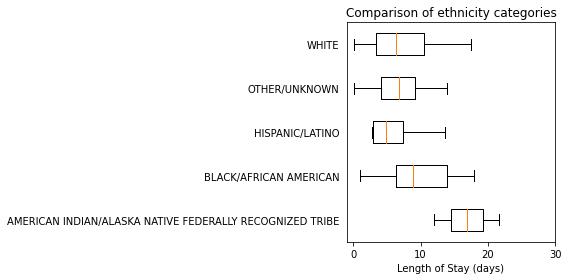

In [16]:
boxplot_los_groupby('ethnicity', los_range=(-1, 30))

In [17]:
df['admission_type'].value_counts()

EMERGENCY    119
ELECTIVE       8
URGENT         2
Name: admission_type, dtype: int64

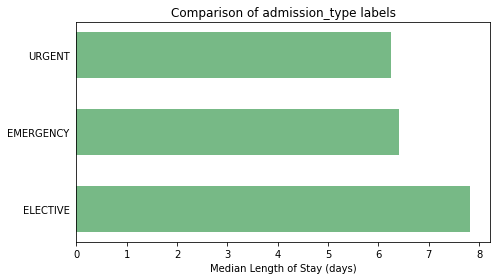

In [18]:
plot_los_groupby('admission_type')

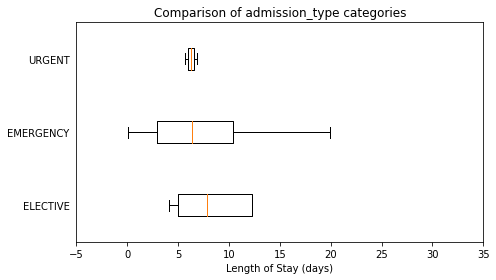

In [19]:
boxplot_los_groupby('admission_type', los_range=(-5, 35), size=(7, 4))

In [20]:
df['insurance'].value_counts()

Medicare      98
Private       24
Medicaid       6
Government     1
Name: insurance, dtype: int64

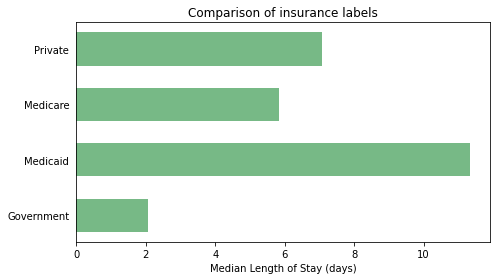

In [21]:
plot_los_groupby('insurance')

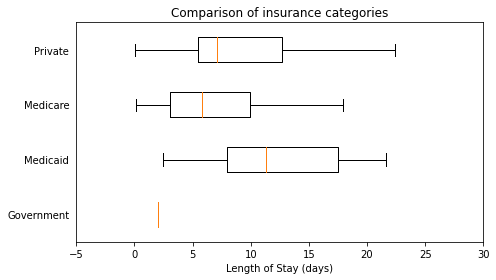

In [22]:
boxplot_los_groupby('insurance', los_range=(-5, 30), size=(7, 4))

In [23]:
df['marital_status'].value_counts(dropna=False)

MARRIED              60
SINGLE               26
NaN                  16
WIDOWED              15
DIVORCED              6
UNKNOWN (DEFAULT)     5
SEPARATED             1
Name: marital_status, dtype: int64

In [24]:
# Replacing NAs as'UNKNOWN'
df['marital_status'] = df['marital_status'].fillna('UNKNOWN (DEFAULT)')
df['marital_status'].value_counts(dropna=False)

MARRIED              60
SINGLE               26
UNKNOWN (DEFAULT)    21
WIDOWED              15
DIVORCED              6
SEPARATED             1
Name: marital_status, dtype: int64

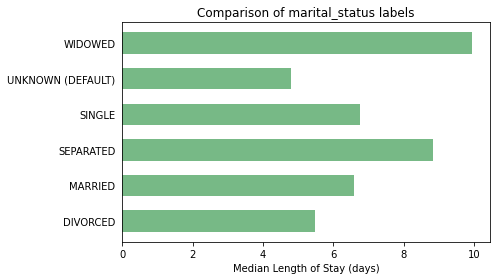

In [25]:
plot_los_groupby('marital_status')

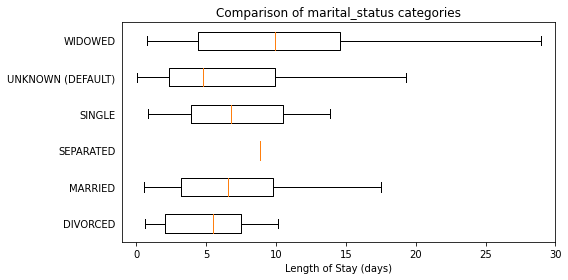

In [26]:
boxplot_los_groupby('marital_status')

## DIAGNOSES_ICD Dataset

Because it's not feasible to have 6985 unique values to use as features for predicting LOS, The diagnosis were reduced into more general categories. After researching the ICD9 coding methodology, the super categories in which the diagnosis codes are arranged are as follows:

001–139: infectious and parasitic diseases\
140–239: neoplasms\
240–279: endocrine, nutritional and metabolic diseases, and immunity disorders\
280–289: diseases of the blood and blood-forming organs\
290–319: mental disorders\
320–389: diseases of the nervous system and sense organs\
390–459: diseases of the circulatory system\
460–519: diseases of the respiratory system\
520–579: diseases of the digestive system\
580–629: diseases of the genitourinary system\
630–679: complications of pregnancy, childbirth, and the puerperium\
680–709: diseases of the skin and subcutaneous tissue\
710–739: diseases of the musculoskeletal system and connective tissue\
740–759: congenital anomalies\
760–779: certain conditions originating in the perinatal period\
780–799: symptoms, signs, and ill-defined conditions\
800–999: injury and poisoning\
E and V codes: external causes of injury and supplemental classification, using 999 as placeholder even though it overlaps with complications of medical care\
Source of these categories: https://en.wikipedia.org/wiki/List_of_ICD-9_codes

In [27]:
df_diagcode

,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662
2,112346,10006,142345,3,5672
3,112347,10006,142345,4,40391
4,112348,10006,142345,5,42731
...,...,...,...,...,...
1756,397673,44228,103379,7,1975
1757,397674,44228,103379,8,45182
1758,397675,44228,103379,9,99592
1759,397676,44228,103379,10,2449


In [28]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['icd9_code']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)

In [29]:
df_diagcode

,row_id,subject_id,hadm_id,seq_num,icd9_code,recode
0,112344,10006,142345,1,99591,99591
1,112345,10006,142345,2,99662,99662
2,112346,10006,142345,3,5672,5672
3,112347,10006,142345,4,40391,40391
4,112348,10006,142345,5,42731,42731
...,...,...,...,...,...,...
1756,397673,44228,103379,7,1975,1975
1757,397674,44228,103379,8,45182,45182
1758,397675,44228,103379,9,99592,99592
1759,397676,44228,103379,10,2449,2449


In [30]:
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

In [31]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), 
            num, df_diagcode['recode'])
    
# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

In [32]:
df_diagcode

,row_id,subject_id,hadm_id,seq_num,icd9_code,recode,cat
0,112344,10006,142345,1,99591,16,injury
1,112345,10006,142345,2,99662,16,injury
2,112346,10006,142345,3,5672,8,digestive
3,112347,10006,142345,4,40391,6,circulatory
4,112348,10006,142345,5,42731,6,circulatory
...,...,...,...,...,...,...,...
1756,397673,44228,103379,7,1975,1,neoplasms
1757,397674,44228,103379,8,45182,6,circulatory
1758,397675,44228,103379,9,99592,16,injury
1759,397676,44228,103379,10,2449,2,endocrine


In [33]:
# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('hadm_id')['cat'].apply(list).reset_index()

In [34]:
hadm_list

,hadm_id,cat
0,100375,"[infectious, genitourinary, genitourinary, end..."
1,100969,"[circulatory, nervous, respiratory, respirator..."
2,101361,"[injury, respiratory, respiratory, respiratory..."
3,102203,"[digestive, genitourinary, misc, endocrine, di..."
4,103379,"[infectious, misc, respiratory, infectious, ne..."
...,...,...
124,198330,"[circulatory, respiratory, circulatory, blood,..."
125,198480,"[digestive, genitourinary, digestive, digestiv..."
126,198503,"[respiratory, neoplasms, neoplasms, genitourin..."
127,199207,"[injury, respiratory, injury, injury, injury, ..."


In [35]:
# Convert diagnoses list into hospital admission-item matrix
hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()

In [36]:
hadm_item

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin
0,0,2,0,0,2,2,1,1,0,1,0,0,0,0,0,0
1,0,4,0,0,1,0,0,0,1,0,0,0,1,0,3,0
2,1,2,0,1,2,1,2,11,1,0,0,0,1,0,5,4
3,0,0,0,4,3,1,0,1,1,1,0,0,0,0,0,0
4,1,1,0,0,1,0,2,1,0,1,0,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,1,3,0,0,0,0,0,1,0,0,0,0,0,0,1,0
125,1,3,0,4,4,1,1,2,0,0,0,0,1,0,2,0
126,1,0,0,0,3,1,1,2,0,1,0,4,0,0,2,0
127,1,2,0,0,2,0,0,7,0,0,0,0,0,0,2,0


In [37]:
# Join the above created dataset using hadm_id to the hadm_list
hadm_item = hadm_item.join(hadm_list['hadm_id'], how="outer")

In [38]:
hadm_item

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,hadm_id
0,0,2,0,0,2,2,1,1,0,1,0,0,0,0,0,0,100375
1,0,4,0,0,1,0,0,0,1,0,0,0,1,0,3,0,100969
2,1,2,0,1,2,1,2,11,1,0,0,0,1,0,5,4,101361
3,0,0,0,4,3,1,0,1,1,1,0,0,0,0,0,0,102203
4,1,1,0,0,1,0,2,1,0,1,0,3,0,0,1,0,103379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,1,3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,198330
125,1,3,0,4,4,1,1,2,0,0,0,0,1,0,2,0,198480
126,1,0,0,0,3,1,1,2,0,1,0,4,0,0,2,0,198503
127,1,2,0,0,2,0,0,7,0,0,0,0,0,0,2,0,199207


In [39]:
# Finally merging with main admissions df
df = df.merge(hadm_item, how='inner', on="hadm_id")

In [40]:
df

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,...,infectious,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin
0,10006,142345,2164-10-23 21:09:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,...,1,6,1,1,0,0,0,0,0,0
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,...,2,0,1,0,0,0,0,0,0,0
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,...,1,0,0,1,0,1,0,0,1,0
3,10017,199207,2149-05-26 17:19:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,...,0,7,0,0,0,0,0,0,2,0
4,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,...,1,1,1,1,1,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,44083,198330,2112-05-28 15:45:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,...,0,1,0,0,0,0,0,0,1,0
125,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,...,1,1,0,0,2,0,1,0,2,0
126,44212,163189,2123-11-24 14:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,ENGL,UNOBTAINABLE,...,2,1,0,2,0,0,1,0,2,2
127,44222,192189,2180-07-19 06:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,...,0,1,0,0,1,0,2,0,0,0


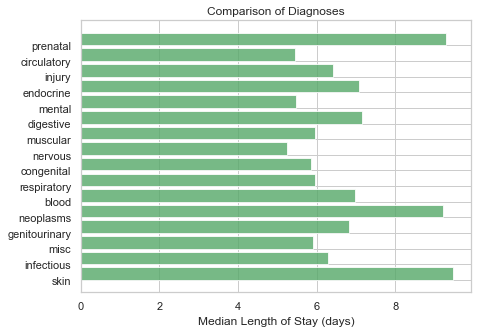

In [41]:
# Explore median LOS by diagnosis category as defined above
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal']

results = []
for variable in diag_cat_list:
    results.append(df[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

## ICUSTAYS Dataset

In [42]:
df_icu['hadm_id'].nunique()

129

In [43]:
df_icu

,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,10006,142345,206504,carevue,MICU,MICU,52,52,2164-10-23 21:10,2164-10-25 12:21,1.6325
1,10011,105331,232110,carevue,MICU,MICU,15,15,2126-08-14 22:34,2126-08-28 18:59,13.8507
2,10013,165520,264446,carevue,MICU,MICU,15,15,2125-10-04 23:38,2125-10-07 15:13,2.6499
3,10017,199207,204881,carevue,CCU,CCU,7,7,2149-05-29 18:52,2149-05-31 22:19,2.1436
4,10019,177759,228977,carevue,MICU,MICU,15,15,2163-05-14 20:43,2163-05-16 3:47,1.2938
...,...,...,...,...,...,...,...,...,...,...,...
131,44083,198330,286428,metavision,CCU,CCU,7,7,2112-05-29 2:01,2112-06-01 16:50,3.6174
132,44154,174245,217724,metavision,MICU,MICU,50,50,2178-05-14 20:29,2178-05-15 11:31,0.6259
133,44212,163189,239396,metavision,MICU,MICU,50,50,2123-11-24 14:14,2123-12-25 17:12,31.1235
134,44222,192189,238186,metavision,CCU,CCU,7,7,2180-07-19 6:56,2180-07-20 14:48,1.3279


In [44]:
# Converting different categories of first care unit into ICU and NICU groups
df_icu['first_careunit'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [45]:
df_icu['cat'] = df_icu['first_careunit']
icu_list = df_icu.groupby('hadm_id')['cat'].apply(list).reset_index()

In [46]:
df_icu['first_careunit'].value_counts()

ICU    136
Name: first_careunit, dtype: int64

In [47]:
# Create admission-ICU matrix
icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
icu_item[icu_item >= 1] = 1
icu_item = icu_item.join(icu_list['hadm_id'], how="outer")

In [48]:
# Merge ICU data with main dataFrame
df = df.merge(icu_item, how='outer', on='hadm_id')

In [49]:
# Replace NA with 0
df['ICU'].fillna(value=0, inplace=True)

In [50]:
df

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,...,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,ICU
0,10006,142345,2164-10-23 21:09:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,...,6,1,1,0,0,0,0,0,0,1
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,...,0,1,0,0,0,0,0,0,0,1
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,...,0,0,1,0,1,0,0,1,0,1
3,10017,199207,2149-05-26 17:19:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,...,7,0,0,0,0,0,0,2,0,1
4,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,...,1,1,1,1,0,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,44083,198330,2112-05-28 15:45:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,...,1,0,0,0,0,0,0,1,0,1
125,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,...,1,0,0,2,0,1,0,2,0,1
126,44212,163189,2123-11-24 14:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,ENGL,UNOBTAINABLE,...,1,0,2,0,0,1,0,2,2,1
127,44222,192189,2180-07-19 06:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,...,1,0,0,1,0,2,0,0,0,1


In [51]:
df.columns

Index(['subject_id', 'hadm_id', 'admittime', 'deathtime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'diagnosis', 'LOS',
       'deceased', 'blood', 'circulatory', 'congenital', 'digestive',
       'endocrine', 'genitourinary', 'infectious', 'injury', 'mental', 'misc',
       'muscular', 'neoplasms', 'nervous', 'prenatal', 'respiratory', 'skin',
       'ICU'],
      dtype='object')

In [52]:
# Drop unnecessary columns
df.drop(columns=['admission_location','subject_id', 'hadm_id', 'admittime', 'religion',
               'discharge_location', 'language',
               'diagnosis', 'deceased',  'deathtime'], inplace=True)

In [53]:
df

,admission_type,insurance,marital_status,ethnicity,LOS,blood,circulatory,congenital,digestive,endocrine,...,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,ICU
0,EMERGENCY,Medicare,SEPARATED,BLACK/AFRICAN AMERICAN,8.837500,2,6,0,2,2,...,6,1,1,0,0,0,0,0,0,1
1,EMERGENCY,Private,SINGLE,OTHER/UNKNOWN,13.852083,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,1
2,EMERGENCY,Medicare,UNKNOWN (DEFAULT),OTHER/UNKNOWN,2.650694,0,4,0,0,1,...,0,0,1,0,1,0,0,1,0,1
3,EMERGENCY,Medicare,DIVORCED,WHITE,8.057639,1,2,0,0,2,...,7,0,0,0,0,0,0,2,0,1
4,EMERGENCY,Medicare,DIVORCED,WHITE,0.636806,1,1,0,4,0,...,1,1,1,1,0,0,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,EMERGENCY,Private,SINGLE,WHITE,10.045139,1,3,0,0,0,...,1,0,0,0,0,0,0,1,0,1
125,EMERGENCY,Medicare,MARRIED,WHITE,0.552778,0,2,0,0,0,...,1,0,0,2,0,1,0,2,0,1
126,EMERGENCY,Medicare,SINGLE,BLACK/AFRICAN AMERICAN,36.011806,2,2,0,6,1,...,1,0,2,0,0,1,0,2,2,1
127,EMERGENCY,Medicare,SINGLE,WHITE,1.253472,0,3,0,0,2,...,1,0,0,1,0,2,0,0,0,1


In [54]:
df['marital_status'].value_counts()

MARRIED              60
SINGLE               26
UNKNOWN (DEFAULT)    21
WIDOWED              15
DIVORCED              6
SEPARATED             1
Name: marital_status, dtype: int64

In [55]:
# replace the SEPARATED category with DIVORCED as its was giving a problem while splitting the data
df['marital_status'] = df['marital_status'].replace('SEPARATED', 'DIVORCED') 

In [56]:
df['marital_status'].value_counts()

MARRIED              60
SINGLE               26
UNKNOWN (DEFAULT)    21
WIDOWED              15
DIVORCED              7
Name: marital_status, dtype: int64

In [57]:
df['LOS'].describe()

count    129.000000
mean       9.332332
std       12.720450
min        0.038194
25%        3.314583
50%        6.634028
75%       10.645139
max      123.984722
Name: LOS, dtype: float64

In [58]:
# Filtering only admission with LOS less than 40 days to reduce the skewness of the data.
#df = df[df['LOS'] <40]

In [150]:
df.to_csv("los_full_data",index=False)

In [59]:
# Randomly splitting the data into test and train with 20% and 80% distribution. Using the train data to generate
# synthetic data and keeping the test data seperate for evaluation purpose

los_use, los_predict = train_test_split(df, test_size=0.2, random_state=30)

In [60]:
# Writing the train and test files into csv for further use 
# Note: Train dataset will be used for generating synthetic data using T-GAN and CT-GAN.
# Test dataset will be used for evaluation of models

los_use.to_csv("los_usecase.csv",index = False)
los_predict.to_csv("los_predict.csv",index = False)

## Use Case 2: Mortality Prediction

In [61]:
patients = pd.read_csv("mimic-iii/patients.csv")
admissions = pd.read_csv("mimic-iii/admissions.csv")
callout = pd.read_csv("mimic-iii/callout.csv")
cptevents = pd.read_csv("mimic-iii/cptevents.csv")
diagnosis = pd.read_csv("mimic-iii/diagnoses_icd.csv")
outputevents = pd.read_csv("mimic-iii/outputevents.csv")
rx = pd.read_csv("mimic-iii/prescriptions.csv")
procevents = pd.read_csv("mimic-iii/procedureevents_mv.csv")
microlabevents = pd.read_csv("mimic-iii/microbiologyevents.csv")
proc = pd.read_csv("mimic-iii/procedures_icd.csv")
transfers = pd.read_csv("mimic-iii/transfers.csv")
inputevents = pd.read_csv("mimic-iii/inputevents_cv.csv")
labevents = pd.read_csv("mimic-iii/labevents.csv")
noteevents = pd.read_csv("mimic-iii/noteevents.csv")

C:\Users\neetu\anaconda3\envs\master\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (17,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Function to roll up tables

In [62]:
def rollup_sub_adm(df1,col):
    df1=df1.groupby(['subject_id','hadm_id']).agg({'row_id':'count'})
    df1.reset_index(inplace=True)
    df1.columns=['subject_id','hadm_id',col]
    print(col,":",df1.shape)
    return df1

In [63]:
callout=rollup_sub_adm(callout,'NUMCALLOUT')
cptevents=rollup_sub_adm(cptevents,'NUMCPTEVENTS')
diagnosis=rollup_sub_adm(diagnosis,'NUMDIAGNOSIS')
outputevents=rollup_sub_adm(outputevents,'NUMOUTEVENTS')
rx=rollup_sub_adm(rx,'NUMRX')
procevents=rollup_sub_adm(procevents,'NUMPROCEVENTS')
microlabevents=rollup_sub_adm(microlabevents,'NUMMICROLABEVENTS')
proc=rollup_sub_adm(proc,'NUMPROC')
transfers=rollup_sub_adm(transfers,'NUMTRANSFERS')
inputevents=rollup_sub_adm(inputevents,'NUMINPUTEVENTS')
labevents=rollup_sub_adm(labevents,'NUMLABEVENTS')
noteevents=rollup_sub_adm(noteevents,'NUMNOTEVENTS')

NUMCALLOUT : (67, 3)
NUMCPTEVENTS : (118, 3)
NUMDIAGNOSIS : (129, 3)
NUMOUTEVENTS : (123, 3)
NUMRX : (122, 3)
NUMPROCEVENTS : (70, 3)
NUMMICROLABEVENTS : (120, 3)
NUMPROC : (113, 3)
NUMTRANSFERS : (129, 3)
NUMINPUTEVENTS : (55, 3)
NUMLABEVENTS : (129, 3)
NUMNOTEVENTS : (0, 3)


In [64]:
mortality=admissions[['subject_id','hadm_id','admission_type','marital_status','ethnicity','hospital_expire_flag']]
mortality.loc[pd.isnull(mortality['marital_status']),'marital_status'] ='UNKNOWN (DEFAULT)'
mortality = mortality.merge(patients[['subject_id','gender']],how='left',on='subject_id')
mortality = mortality.merge(callout,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(cptevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(diagnosis,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(outputevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(rx,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(procevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(microlabevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(proc,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(transfers,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(inputevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(labevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.merge(noteevents,how='left',on=['subject_id','hadm_id'])
mortality = mortality.fillna(0)

C:\Users\neetu\anaconda3\envs\master\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [65]:
#Exporing data
mortality.to_csv('mortality_full_data.csv',index=False)

### Exploratory Analysis

In [66]:
mortality.shape

(129, 19)

In [67]:
mortality.columns

Index(['subject_id', 'hadm_id', 'admission_type', 'marital_status',
       'ethnicity', 'hospital_expire_flag', 'gender', 'NUMCALLOUT',
       'NUMCPTEVENTS', 'NUMDIAGNOSIS', 'NUMOUTEVENTS', 'NUMRX',
       'NUMPROCEVENTS', 'NUMMICROLABEVENTS', 'NUMPROC', 'NUMTRANSFERS',
       'NUMINPUTEVENTS', 'NUMLABEVENTS', 'NUMNOTEVENTS'],
      dtype='object')

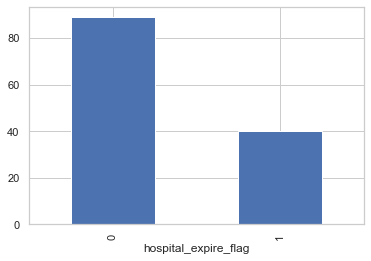

In [68]:
mortality.groupby('hospital_expire_flag').size().plot.bar()
plt.show()

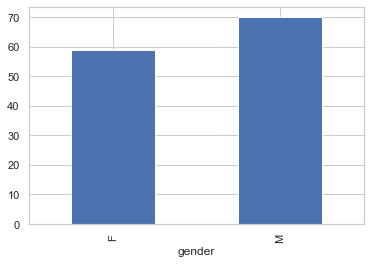

In [69]:
mortality.groupby('gender').size().plot.bar()
plt.show()

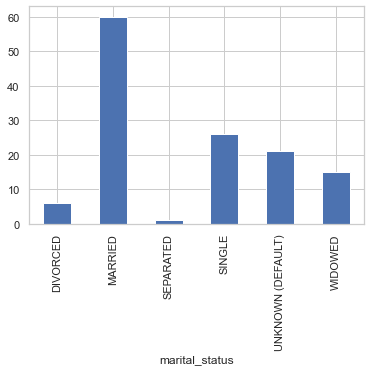

In [70]:
mortality.groupby('marital_status').size().plot.bar()
plt.show()

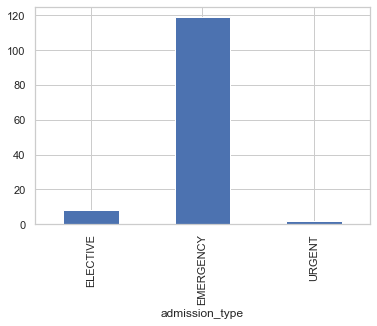

In [71]:
mortality.groupby('admission_type').size().plot.bar()
plt.show()

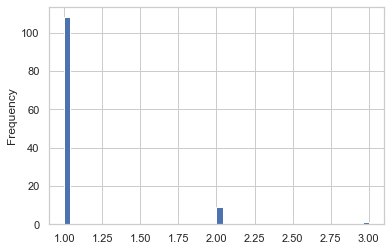

In [72]:
mortality.groupby('NUMLABEVENTS').size().plot.hist(bins=50)
plt.show()

In [73]:
mortality.dtypes

subject_id                int64
hadm_id                   int64
admission_type           object
marital_status           object
ethnicity                object
hospital_expire_flag      int64
gender                   object
NUMCALLOUT              float64
NUMCPTEVENTS            float64
NUMDIAGNOSIS              int64
NUMOUTEVENTS            float64
NUMRX                   float64
NUMPROCEVENTS           float64
NUMMICROLABEVENTS       float64
NUMPROC                 float64
NUMTRANSFERS              int64
NUMINPUTEVENTS          float64
NUMLABEVENTS              int64
NUMNOTEVENTS            float64
dtype: object

## Generating synthetic data after proper split and one hot encoding

In [74]:
from sklearn import tree, neighbors, datasets, linear_model, svm, naive_bayes
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn import metrics, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.utils.multiclass import unique_labels
import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import xgboost as xgb
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [75]:
import tensorflow as tf

In [76]:
from tensorflow.keras import models, regularizers, layers, optimizers, losses
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [77]:
#One Hot encoding
mortality_pred=mortality.drop(columns=['subject_id','hadm_id','ethnicity','marital_status'])
mortality_pred=pd.get_dummies(mortality_pred,prefix=['admission_type','gender'])
mortality_pred.head()

,hospital_expire_flag,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,NUMINPUTEVENTS,NUMLABEVENTS,NUMNOTEVENTS,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT,gender_F,gender_M
0,0,0.0,4.0,21,3.0,54.0,0.0,20.0,7.0,3,6.0,251,0.0,0,1,0,1,0
1,1,0.0,0.0,6,261.0,0.0,0.0,13.0,2.0,2,573.0,700,0.0,0,1,0,1,0
2,1,0.0,1.0,9,32.0,36.0,0.0,3.0,1.0,2,430.0,148,0.0,0,1,0,1,0
3,0,1.0,13.0,14,25.0,105.0,0.0,2.0,2.0,6,163.0,302,0.0,0,1,0,1,0
4,1,0.0,5.0,14,22.0,99.0,0.0,13.0,4.0,2,821.0,287,0.0,0,1,0,0,1


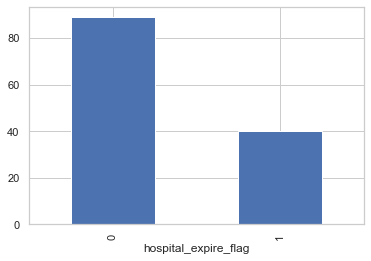

In [78]:
mortality_pred.groupby('hospital_expire_flag').size().plot.bar()
plt.show()

In [79]:
# Split data using target variable
mp_train, mp_test = train_test_split(mortality_pred, test_size=0.20, random_state=42,stratify=mortality_pred['hospital_expire_flag'])

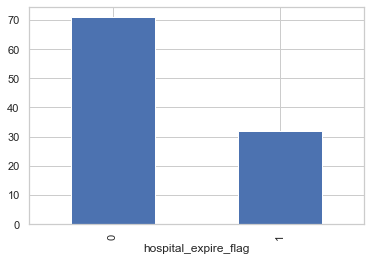

In [80]:
mp_train.groupby('hospital_expire_flag').size().plot.bar()
plt.show()

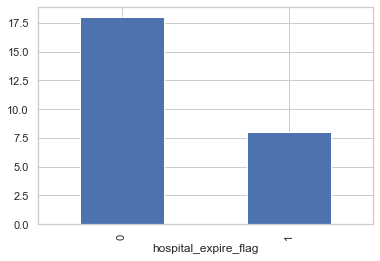

In [81]:
mp_test.groupby('hospital_expire_flag').size().plot.bar()
plt.show()

In [82]:
# Writing csv files to disk
mp_train.to_csv('mortality_train.csv',index=False)
mp_test.to_csv('mortality_test.csv',index=False)

## Generate synthetic data using CTGAN for Mortality Prediction

In [83]:
pip install ctgan

Note: you may need to restart the kernel to use updated packages.


In [84]:
from ctgan import CTGAN

In [85]:
mp_train

,hospital_expire_flag,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,NUMINPUTEVENTS,NUMLABEVENTS,NUMNOTEVENTS,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT,gender_F,gender_M
32,0,0.0,7.0,17,36.0,32.0,0.0,4.0,2.0,3,76.0,197,0.0,0,1,0,0,1
58,0,1.0,11.0,7,75.0,75.0,12.0,11.0,4.0,4,0.0,219,0.0,0,1,0,1,0
62,0,1.0,5.0,11,36.0,64.0,8.0,1.0,3.0,7,0.0,145,0.0,1,0,0,1,0
90,0,1.0,15.0,37,0.0,125.0,0.0,18.0,3.0,3,0.0,356,0.0,0,1,0,0,1
117,0,1.0,0.0,8,8.0,31.0,6.0,1.0,2.0,2,0.0,64,0.0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0,1.0,7.0,11,49.0,77.0,8.0,4.0,3.0,4,0.0,264,0.0,0,1,0,1,0
49,0,0.0,0.0,5,50.0,28.0,0.0,1.0,3.0,6,41.0,213,0.0,0,1,0,0,1
11,1,0.0,4.0,14,28.0,33.0,0.0,3.0,1.0,2,174.0,177,0.0,0,1,0,1,0
24,0,1.0,3.0,11,69.0,83.0,0.0,3.0,3.0,5,154.0,348,0.0,1,0,0,1,0


In [86]:
mp_train.dtypes

hospital_expire_flag          int64
NUMCALLOUT                  float64
NUMCPTEVENTS                float64
NUMDIAGNOSIS                  int64
NUMOUTEVENTS                float64
NUMRX                       float64
NUMPROCEVENTS               float64
NUMMICROLABEVENTS           float64
NUMPROC                     float64
NUMTRANSFERS                  int64
NUMINPUTEVENTS              float64
NUMLABEVENTS                  int64
NUMNOTEVENTS                float64
admission_type_ELECTIVE       uint8
admission_type_EMERGENCY      uint8
admission_type_URGENT         uint8
gender_F                      uint8
gender_M                      uint8
dtype: object

In [87]:
discrete_columns = ['hospital_expire_flag','NUMDIAGNOSIS','NUMTRANSFERS','NUMLABEVENTS','admission_type_ELECTIVE','admission_type_EMERGENCY','admission_type_URGENT','gender_F','gender_M']  # List of discrete columns

In [88]:
ctgan = CTGAN(epochs=100)

In [89]:
ctgan.fit(mp_train, discrete_columns)

In [90]:
num_samples = 150
samples = ctgan.sample(num_samples)

In [91]:
samples #Synthetic data generated by using CTGAN for use case Mortality Prediction

,hospital_expire_flag,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,NUMINPUTEVENTS,NUMLABEVENTS,NUMNOTEVENTS,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_URGENT,gender_F,gender_M
0,1,0.610350,7.754311,9,295.181849,133.544444,6.050202,13.415190,-2.699714,4,504.871891,615,0.000620,0,0,0,0,1
1,0,-0.346629,3.286338,5,44.305414,49.973825,9.098415,16.255445,-1.852124,4,2284.080124,284,0.001739,0,0,0,1,0
2,1,0.677005,11.274138,23,68.885245,394.252274,3.829683,19.941071,0.080226,3,-6.957084,290,0.000694,0,1,0,0,1
3,1,0.051705,14.133001,9,11.055861,265.424653,5.538769,18.003999,-0.025953,3,-110.334404,185,0.002783,0,1,0,1,0
4,1,-0.302815,-3.224137,11,57.824599,98.445231,2.214135,161.636823,-2.077338,3,-374.278853,136,0.002582,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0,-0.154996,12.432665,17,52.299664,122.258005,6.218223,31.642717,1.140193,9,204.077466,275,0.001613,0,0,0,1,0
146,0,-0.294472,6.747961,8,12.635626,60.900360,-0.255145,103.943601,-3.724143,6,-305.601483,479,0.002865,0,1,0,0,1
147,1,-0.051525,1.697008,17,3.406263,164.652590,25.344849,11.936660,1.746838,2,2503.327738,148,0.002396,0,1,0,1,0
148,0,-0.085309,-5.403964,9,78.650381,149.577161,8.759223,9.651181,1.454642,2,-277.806158,1147,0.001031,0,1,0,1,1


In [92]:
samples.to_csv("syn_ctgan_mp.csv",index = False)

## Evaluation of Synthetic data for Mortality Prediction use case (CTGAN)

### 1. Model Compatability

## Generate Synthetic data using CTGAN for the use case of Length Of Stay

In [93]:
los_use

,admission_type,insurance,marital_status,ethnicity,LOS,blood,circulatory,congenital,digestive,endocrine,...,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,ICU
88,EMERGENCY,Medicare,MARRIED,HISPANIC/LATINO,2.862500,0,5,0,1,3,...,4,1,0,0,0,2,0,1,0,1
20,EMERGENCY,Medicare,MARRIED,WHITE,5.578472,1,2,0,2,1,...,0,0,1,0,0,0,0,0,0,1
106,EMERGENCY,Medicare,MARRIED,WHITE,32.138889,1,3,0,1,3,...,4,2,1,1,0,2,1,0,0,1
21,EMERGENCY,Medicare,MARRIED,WHITE,7.032639,0,2,0,3,1,...,1,0,2,0,0,0,0,1,0,1
32,EMERGENCY,Private,UNKNOWN (DEFAULT),WHITE,5.812500,2,4,0,0,0,...,7,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,EMERGENCY,Medicare,MARRIED,WHITE,2.107639,1,3,0,0,2,...,0,0,0,0,0,1,0,2,0,1
126,EMERGENCY,Medicare,SINGLE,BLACK/AFRICAN AMERICAN,36.011806,2,2,0,6,1,...,1,0,2,0,0,1,0,2,2,1
45,URGENT,Private,MARRIED,OTHER/UNKNOWN,6.830556,1,3,0,0,1,...,1,1,0,0,0,0,0,1,0,1
128,EMERGENCY,Private,SINGLE,WHITE,9.615278,1,1,0,0,1,...,1,0,1,0,3,0,0,1,0,1


In [94]:
los_use.dtypes

admission_type     object
insurance          object
marital_status     object
ethnicity          object
LOS               float64
blood               uint8
circulatory         uint8
congenital          uint8
digestive           uint8
endocrine           uint8
genitourinary       uint8
infectious          uint8
injury              uint8
mental              uint8
misc                uint8
muscular            uint8
neoplasms           uint8
nervous             uint8
prenatal            uint8
respiratory         uint8
skin                uint8
ICU                 uint8
dtype: object

In [95]:
Discrete_columns=['admission_type','insurance','marital_status','ethnicity','blood','circulatory','congenital','digestive','endocrine','genitourinary','infectious','injury','mental','misc','muscular','neoplasms','nervous','prenatal','respiratory','skin','ICU']

In [96]:
Ctgan = CTGAN(epochs=100)

In [97]:
Ctgan.fit(los_use, Discrete_columns)

In [98]:
num_sample = 150
sample = Ctgan.sample(num_sample)

In [99]:
sample #synthetic data generated by CTGAN for use case of Length of Stay

,admission_type,insurance,marital_status,ethnicity,LOS,blood,circulatory,congenital,digestive,endocrine,...,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,ICU
0,EMERGENCY,Medicare,MARRIED,WHITE,37.450182,0,4,0,1,1,...,1,0,1,0,0,1,0,2,0,1
1,EMERGENCY,Private,WIDOWED,WHITE,44.675260,0,3,0,2,1,...,6,0,2,0,0,0,0,2,0,1
2,EMERGENCY,Medicare,MARRIED,WHITE,43.225047,0,3,0,2,3,...,5,0,0,0,0,3,0,1,0,1
3,EMERGENCY,Medicare,MARRIED,WHITE,15.954860,0,2,0,1,1,...,1,0,0,0,3,0,0,2,0,1
4,EMERGENCY,Medicare,MARRIED,WHITE,13.538330,2,2,0,0,0,...,3,1,1,0,4,1,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,EMERGENCY,Medicare,MARRIED,WHITE,44.164348,0,2,0,2,1,...,2,1,1,0,1,3,0,0,0,1
146,EMERGENCY,Medicare,MARRIED,BLACK/AFRICAN AMERICAN,15.693735,3,0,0,1,1,...,0,0,0,0,7,0,0,2,0,1
147,EMERGENCY,Private,MARRIED,WHITE,14.246586,0,2,0,1,2,...,2,0,4,0,0,1,0,2,0,1
148,EMERGENCY,Medicaid,DIVORCED,WHITE,15.469444,0,1,0,0,1,...,4,0,0,0,0,0,0,5,0,1


In [100]:
sample.to_csv("syn_ctgan_los.csv",index = False)

## Evaluation of Synthetic data for the Use case "length Of Stay"

### 1. Model Compatability

In [101]:
#Loading data into dataframes
# the command below helps to import the dataset into the Jupyter notebook
#los_use = pd.read_csv("los_usecase.csv")
#los_predict = pd.read_csv("los_predict.csv")
#los_tgan = pd.read_csv(r"C:\Users\poona\Desktop\ELP\data_used\los_usecase_tgan.csv")
#los_ctgan = pd.read_csv("los_usecase_ctgan.csv")

#Evaluating quality of data
#Viewing top 5 rows to get a sense of the data

In [102]:
# Loading required datasets i.e. los_use, los_predict, sample
los_use['LOS']

88      2.862500
20      5.578472
106    32.138889
21      7.032639
32      5.812500
         ...    
116     2.107639
126    36.011806
45      6.830556
128     9.615278
37      4.809028
Name: LOS, Length: 103, dtype: float64

In [103]:
los_use['LOS'].skew()

6.347715317966986

In [104]:
los_predict['LOS'].skew()

1.930163410755252

In [105]:
sample['LOS'].skew()

5.471218414081868

Hence, LOS in los_use, los_predict, sample is right skewed

In [106]:
# As LOS(predictor variable) is right skewed conitinuous field.
# So to make it a normal distribution a logarithmic transformation is done on LOS field for all the 
#dataset i.e. los_use, los_predict, sample(syntehtic data generated by CTGAN)
los_use['LOS']=np.log(los_use['LOS']+1)
los_predict['LOS']=np.log(los_predict['LOS']+1)
sample['LOS']=np.log(sample['LOS']+1)

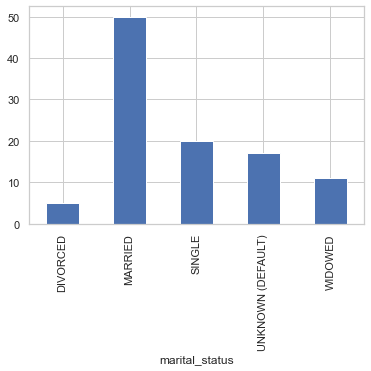

In [107]:
los_use.groupby('marital_status').size().plot.bar()
plt.show()

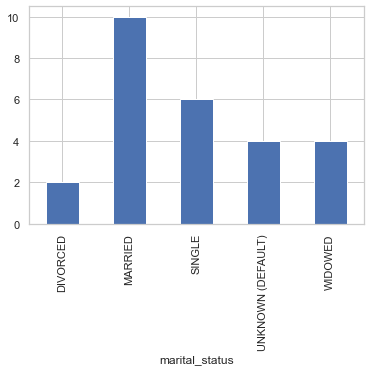

In [108]:
los_predict.groupby('marital_status').size().plot.bar()
plt.show()

### We have categorical columns like ethnicity, admission_type, insurance and marital_status which are converted into dummy variables using one hot encoding

In [109]:
# Create dummy columns for categorical variables of dataset los_use
prefix_cols = ['ADM', 'INS', 'ETH', 'MAR']
dummy_cols = ['admission_type', 'insurance',
             'ethnicity', 'marital_status']
los_use = pd.get_dummies(los_use, prefix=prefix_cols, columns=dummy_cols)

In [110]:
# Create dummy columns for categorical variables of dataset los_use
prefix_cols = ['ADM', 'INS', 'ETH', 'MAR']
dummy_cols = ['admission_type', 'insurance',
             'ethnicity', 'marital_status']
los_predict = pd.get_dummies(los_predict, prefix=prefix_cols, columns=dummy_cols)

In [111]:
# Ensure both DataFrames have the same columns (as los_use and los_predict were having different number of columns)
missing_columns = set(los_use.columns) - set(los_predict.columns)
for column in missing_columns:
    los_predict[column] = 0

In [112]:
los_use.shape

(103, 35)

In [113]:
los_predict.shape

(26, 35)

### Selection of Features for the predictive model and the target variable (i.e. Length of Stay)

In [114]:
#Selecting the required columns - features and target variable.
X_train = los_use.iloc[:,1:35]
y_train = los_use.iloc[:,0]

In [115]:
#Selecting the required columns - features and target variable.
X_test = los_predict.iloc[:,1:35]
y_test = los_predict.iloc[:,0]

In [116]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((103, 34), (103,), (26, 34), (26,))

#### Scaling on test and train dataset: Scaling on predictor variables of test and train is done to normalise the dataset. This step is important for regularisation

In [117]:
scaler = StandardScaler()
scaler.fit(X_train)
x_train_scaled=scaler.transform(X_train)
x_test_scaled=scaler.transform(X_test)

### Data Exploration after split into train and test

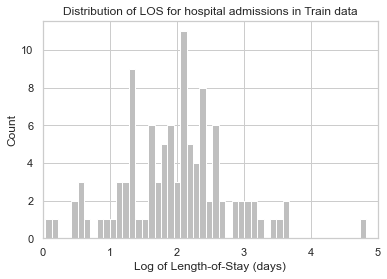

In [118]:
# Plot LOS Distribution for train data
plt.hist(y_train, bins=50, color = '0.75')
plt.xlim(0, 5)
plt.title('Distribution of LOS for hospital admissions in Train data')
plt.ylabel('Count')
plt.xlabel('Log of Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

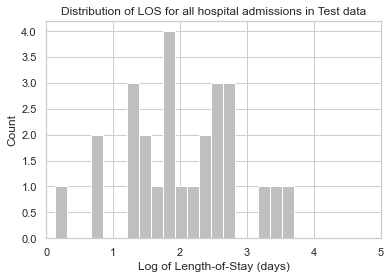

In [119]:
# Plot LOS Distribution for test data
plt.hist(y_test, bins=20, color = '0.75')
plt.xlim(0, 5)
plt.title('Distribution of LOS for all hospital admissions in Test data')
plt.ylabel('Count')
plt.xlabel('Log of Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

## Model 1 - Random Forest
### Random Forest for Orignal Dataset

In [120]:
# importing required libraries
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1,
                           random_state=123,
                            min_samples_split=5,
                            min_samples_leaf=2,
                            criterion="mse")

params = {'n_estimators':[50, 100, 150],
          'max_depth':list(range(5, 15, 2)),
          'max_features':list(range(5, 20, 2))}

model = GridSearchCV(rf, params,
                     scoring='neg_mean_squared_error',
                     n_jobs=-1, cv=5)
model.fit(x_train_scaled,y_train)
print("Best Score:",model.best_score_)
print("Best parameters:",model.best_params_)

Best Score: -0.5170175943233447
Best parameters: {'max_depth': 13, 'max_features': 7, 'n_estimators': 150}


In [121]:
# Model with best parameter
rf = RandomForestRegressor(n_jobs=-1,random_state=123,
                n_estimators=150,
                max_depth=13,
                max_features = 7,
                min_samples_split= 5,
                min_samples_leaf=2,
                criterion="mse")
rf.fit(x_train_scaled,y_train)

RandomForestRegressor(max_depth=13, max_features=7, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=150, n_jobs=-1,
                      random_state=123)

In [122]:
#predicting on the test set
y_pred = rf.predict(x_test_scaled)

### Results of Orignal Dataset for Random Forest Regressor Model for LOS dataset

In [123]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_pred))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred))

Mean Absolute Error: 0.7029333624101616
Mean Squared Error: 0.7160587638213212
Root Mean Squared Error: 0.8462025548421142
Explained Variance Score: -0.034846796212459896
Coefficient of Determination: -0.039729418073219724


        Feature  Importance
9          misc    0.114794
14  respiratory    0.099653
4     endocrine    0.083813
3     digestive    0.081633
1   circulatory    0.067509


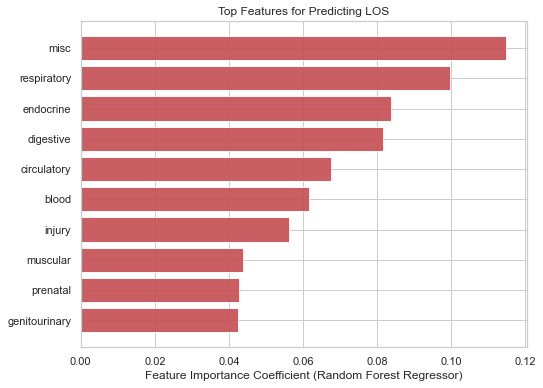

In [124]:
# Assuming 'x_train_scaled' is a NumPy array with feature names
# Replace 'x_train_scaled' with your actual training data

# Create a DataFrame from the NumPy array with column names
x_train_df = pd.DataFrame(x_train_scaled, columns=['blood', 'circulatory', 'congenital', 'digestive', 'endocrine',
       'genitourinary', 'infectious', 'injury', 'mental', 'misc', 'muscular',
       'neoplasms', 'nervous', 'prenatal', 'respiratory', 'skin', 'ICU',
       'ADM_ELECTIVE', 'ADM_EMERGENCY', 'ADM_URGENT', 'INS_Government',
       'INS_Medicaid', 'INS_Medicare', 'INS_Private',
       'ETH_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
       'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC/LATINO',
       'ETH_OTHER/UNKNOWN', 'ETH_WHITE', 'MAR_DIVORCED', 'MAR_MARRIED',
       'MAR_SINGLE', 'MAR_UNKNOWN (DEFAULT)', 'MAR_WIDOWED'])

# Extract feature importances from the best model
best_rf_model = model.best_estimator_
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame to store feature importances
feature_imp = pd.DataFrame({'Feature': x_train_df.columns,
                             'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_imp = feature_imp.sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_imp.head())

# Plot feature importance
fig, ax = plt.subplots(figsize=(8, 6))
ind = range(0, min(10, len(feature_imp)))  # Display top 10 features or less if there are fewer features
ax.barh(ind, feature_imp['Importance'].values[:10],  # Use [:10] to get the top 10 features
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp['Feature'].tolist()[:10])  # Display top 10 feature names
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top Features for Predicting LOS")
ax.set_xlabel('Feature Importance Coefficient (Random Forest Regressor)')
plt.gca().invert_yaxis()
plt.show()

### Random forest for CTGAN generated Data

In [125]:
#Viewing top 5 rows to get a sense of the data
sample.head(5)

,admission_type,insurance,marital_status,ethnicity,LOS,blood,circulatory,congenital,digestive,endocrine,...,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,ICU
0,EMERGENCY,Medicare,MARRIED,WHITE,3.649363,0,4,0,1,1,...,1,0,1,0,0,1,0,2,0,1
1,EMERGENCY,Private,WIDOWED,WHITE,3.821557,0,3,0,2,1,...,6,0,2,0,0,0,0,2,0,1
2,EMERGENCY,Medicare,MARRIED,WHITE,3.789291,0,3,0,2,3,...,5,0,0,0,0,3,0,1,0,1
3,EMERGENCY,Medicare,MARRIED,WHITE,2.830554,0,2,0,1,1,...,1,0,0,0,3,0,0,2,0,1
4,EMERGENCY,Medicare,MARRIED,WHITE,2.676789,2,2,0,0,0,...,3,1,1,0,4,1,0,0,2,1


In [126]:
print(sample.isnull().sum())  # LOS have NAN values

admission_type    0
insurance         0
marital_status    0
ethnicity         0
LOS               2
blood             0
circulatory       0
congenital        0
digestive         0
endocrine         0
genitourinary     0
infectious        0
injury            0
mental            0
misc              0
muscular          0
neoplasms         0
nervous           0
prenatal          0
respiratory       0
skin              0
ICU               0
dtype: int64


In [127]:
# drop the NAN value from the synthetic data
sample = sample.dropna(subset=['LOS'])

In [128]:
# Converting float to integers
sample.iloc[:,5:22] = sample.iloc[:,5:22].astype(int)

#### One-Hot encoding for CTGAN generated dataset

In [129]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'ETH', 'MAR']
dummy_cols = ['admission_type', 'insurance',
             'ethnicity', 'marital_status']
sample = pd.get_dummies(sample, prefix=prefix_cols, columns=dummy_cols)

In [130]:
sample.shape

(148, 35)

#### Selection of Features for the predictive model and the target variable (i.e. Length of Stay)

In [131]:
#Selecting the required columns - features and target variable. The model doesnot include the patient demographic details
X_train_ctgan = sample.iloc[:,1:35]
y_train_ctgan = sample.iloc[:,0]

In [132]:
X_train_ctgan.shape, y_train_ctgan.shape

((148, 34), (148,))

#### Scaling

In [133]:
scaler = StandardScaler()
scaler.fit(X_train_ctgan)
x_train_ctgan_scaled=scaler.transform(X_train_ctgan)

### Random Forest for synthetic Dataset generated by using CTGAN

In [134]:
# importing required libraries
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1,
                           random_state=123,
                            min_samples_split=5,
                            min_samples_leaf=2,
                            criterion="mse")

params = {'n_estimators':[50, 100, 150],
          'max_depth':list(range(5, 15, 2)),
          'max_features':list(range(5, 20, 2))}

model = GridSearchCV(rf, params,
                     scoring='neg_mean_squared_error',
                     n_jobs=-1, cv=5)
model.fit(x_train_ctgan_scaled,y_train_ctgan)
print("Best Score:",model.best_score_)
print("Best parameters:",model.best_params_)### Random Forest for Synthetic Dataset

Best Score: -0.5130442466063
Best parameters: {'max_depth': 13, 'max_features': 5, 'n_estimators': 50}


In [135]:
# Model with best parameter
rf = RandomForestRegressor(n_jobs=-1,random_state=123,
                n_estimators=150,
                max_depth=13,
                max_features = 7,
                min_samples_split= 5,
                min_samples_leaf=2,
                criterion="mse")
rf.fit(x_train_ctgan_scaled,y_train_ctgan)

RandomForestRegressor(max_depth=13, max_features=7, min_samples_leaf=2,
                      min_samples_split=5, n_estimators=150, n_jobs=-1,
                      random_state=123)

In [136]:
#predicting on the test set
y_pred_ctgan = rf.predict(x_test_scaled)

### Results of Syntehtic Dataset (CTGAN) for Random Forest Regressor Model for LOS dataset

In [137]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_ctgan))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_ctgan))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ctgan)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_pred_ctgan))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred_ctgan))

Mean Absolute Error: 1.0726157752443375
Mean Squared Error: 1.6082988616129688
Root Mean Squared Error: 1.2681872344464633
Explained Variance Score: 0.15516403843943438
Coefficient of Determination: -1.3352771084719777


                       Feature  Importance
7                       injury    0.084655
1                  circulatory    0.079948
25  ETH_BLACK/AFRICAN AMERICAN    0.076697
4                    endocrine    0.069427
3                    digestive    0.062702


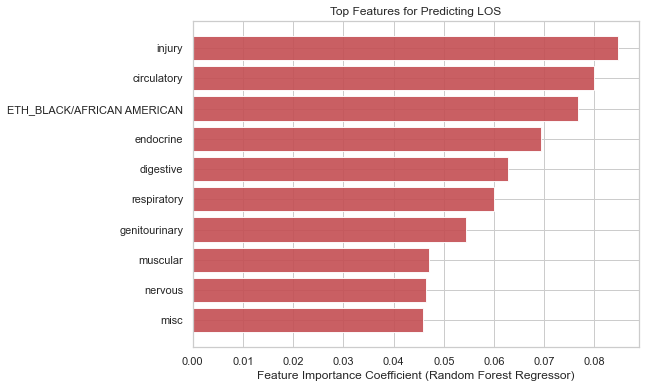

In [138]:
# Assuming 'x_train_scaled' is a NumPy array with feature names
# Replace 'x_train_scaled' with your actual training data

# Create a DataFrame from the NumPy array with column names
x_train_ctgan_df = pd.DataFrame(x_train_ctgan_scaled, columns=['blood', 'circulatory', 'congenital', 'digestive', 'endocrine',
       'genitourinary', 'infectious', 'injury', 'mental', 'misc', 'muscular',
       'neoplasms', 'nervous', 'prenatal', 'respiratory', 'skin', 'ICU',
       'ADM_ELECTIVE', 'ADM_EMERGENCY', 'ADM_URGENT', 'INS_Government',
       'INS_Medicaid', 'INS_Medicare', 'INS_Private',
       'ETH_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
       'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC/LATINO',
       'ETH_OTHER/UNKNOWN', 'ETH_WHITE', 'MAR_DIVORCED', 'MAR_MARRIED',
       'MAR_SINGLE', 'MAR_UNKNOWN (DEFAULT)', 'MAR_WIDOWED'])

# Extract feature importances from the best model
best_rf_model = model.best_estimator_
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame to store feature importances
feature_imp = pd.DataFrame({'Feature': x_train_ctgan_df.columns,
                             'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_imp = feature_imp.sort_values(by='Importance', ascending=False)

# Display the top features
print(feature_imp.head())

# Plot feature importance
fig, ax = plt.subplots(figsize=(8, 6))
ind = range(0, min(10, len(feature_imp)))  # Display top 10 features or less if there are fewer features
ax.barh(ind, feature_imp['Importance'].values[:10],  # Use [:10] to get the top 10 features
        align='center', color='#c44e52', alpha=0.9)
ax.set_yticks(ind)
ax.set_yticklabels(feature_imp['Feature'].tolist()[:10])  # Display top 10 feature names
ax.tick_params(left=False, top=False, right=False) 
ax.set_title("Top Features for Predicting LOS")
ax.set_xlabel('Feature Importance Coefficient (Random Forest Regressor)')
plt.gca().invert_yaxis()
plt.show()

## Model 2 - XG Boost
### XG Boost for Orignal Dataset for LOS

In [141]:
import warnings
warnings.filterwarnings('ignore')
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
xgb_model = xgb.XGBRegressor(nthread=-1,objective='reg:squarederror') 

grid = GridSearchCV(xgb_model, params)
grid.fit(x_train_scaled, y_train)
grid.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.5,
 'max_depth': 3,
 'min_child_weight': 4,
 'subsample': 0.7}

In [142]:
xg = xgb.XGBRegressor(nthread=-1,colsample_bytree= 1.0,gamma= 0.5, max_depth= 4,min_child_weight= 5,subsample= 0.8)
xg.fit(x_train_scaled,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             gamma=0.5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=20, nthread=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Results of orignal dataset

In [143]:
#predicting on the test set
y_pred = xg.predict(x_test_scaled)

In [144]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_pred))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_pred))

Mean Absolute Error: 0.7413448462876554
Mean Squared Error: 0.7982641109724671
Root Mean Squared Error: 0.8934562725575701
Explained Variance Score: -0.13647502882897644
Coefficient of Determination: -0.1590929704440356


### XG Boost for CTGAN generated Data

In [145]:
import warnings
warnings.filterwarnings('ignore')
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
xgb_Model = xgb.XGBRegressor(nthread=-1,objective='reg:squarederror') 

grid = GridSearchCV(xgb_Model, params)
grid.fit(x_train_ctgan_scaled, y_train_ctgan)
grid.best_params_

{'colsample_bytree': 0.6,
 'gamma': 0.3,
 'max_depth': 2,
 'min_child_weight': 5,
 'subsample': 1.0}

In [146]:
xg = xgb.XGBRegressor(nthread=-1,colsample_bytree= 1.0,gamma= 0.5, max_depth= 4,min_child_weight= 5,subsample= 0.8)
xg.fit(x_train_ctgan_scaled,y_train_ctgan)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             gamma=0.5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=20, nthread=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [147]:
#predicting on the test set
y_Pred_ctgan = xg.predict(x_test_scaled)

### Results of Synthetic dataset generated by CTGAN

In [148]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_Pred_ctgan))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_Pred_ctgan))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_Pred_ctgan)))
print('Explained Variance Score:', metrics.explained_variance_score(y_test,y_Pred_ctgan))
print('Coefficient of Determination:', metrics.r2_score(y_test,y_Pred_ctgan))

Mean Absolute Error: 1.1572594502500786
Mean Squared Error: 1.7197528823240544
Root Mean Squared Error: 1.311393488745485
Explained Variance Score: 0.21100955326776105
Coefficient of Determination: -1.4971102288117688


## Privacy Risk Measurement

### 1. Original dataset and CTGAN synthetic dataset for LOS use case

In [151]:
#Load up datasets
original = pd.read_csv('los_full_data.csv')
ctgan = pd.read_csv('syn_ctgan_los.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'los_full_data.csv'

In [ ]:
#Loading the datasets which are los_full_data i.e df and syn_ctgan_los i.e. sample

#### Understanding the Dataset

In [152]:
df.head()

,admission_type,insurance,marital_status,ethnicity,LOS,blood,circulatory,congenital,digestive,endocrine,...,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,ICU
0,EMERGENCY,Medicare,DIVORCED,BLACK/AFRICAN AMERICAN,8.837500,2,6,0,2,2,...,6,1,1,0,0,0,0,0,0,1
1,EMERGENCY,Private,SINGLE,OTHER/UNKNOWN,13.852083,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,1
2,EMERGENCY,Medicare,UNKNOWN (DEFAULT),OTHER/UNKNOWN,2.650694,0,4,0,0,1,...,0,0,1,0,1,0,0,1,0,1
3,EMERGENCY,Medicare,DIVORCED,WHITE,8.057639,1,2,0,0,2,...,7,0,0,0,0,0,0,2,0,1
4,EMERGENCY,Medicare,DIVORCED,WHITE,0.636806,1,1,0,4,0,...,1,1,1,1,0,0,0,2,0,1


In [153]:
sample.head()

,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,...,ETH_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETH_BLACK/AFRICAN AMERICAN,ETH_HISPANIC/LATINO,ETH_OTHER/UNKNOWN,ETH_WHITE,MAR_DIVORCED,MAR_MARRIED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED
0,3.649363,0,4,0,1,1,1,2,1,0,...,0,0,0,0,1,0,1,0,0,0
1,3.821557,0,3,0,2,1,3,2,6,0,...,0,0,0,0,1,0,0,0,0,1
2,3.789291,0,3,0,2,3,1,0,5,0,...,0,0,0,0,1,0,1,0,0,0
3,2.830554,0,2,0,1,1,1,0,1,0,...,0,0,0,0,1,0,1,0,0,0
4,2.676789,2,2,0,0,0,0,2,3,1,...,0,0,0,0,1,0,1,0,0,0
